## Task description

A simple model of forest fire may be defined as a two-dimensional cellural automation on a grid of cells, which take one of three states: empty, occupied by a tree or burning. The automaton evolves according to the following rules, which are executed simultaneously for every cell at a given generation:
1. A burning cell turns into an empty cell.
2. A cell occupied by a tree becomes a burning cell, if any of its eight neigboring cells are burning.

Implement the model in Python on a $L \times L$ square lattice. At the beginning of the simulation, every cell of the grid should be populated by a tree with probability $p$. Assume that initially all trees at one of the edges are burning.
1. Find the so called percolation threshold $p^\star$, i.e. the probability that fire hist the opposite edge of the grid during the simulation. Use $L = 20$, $50$ and $100$ for the linear size of the lattice.
2. Plot the average size of the biggest cluster of burned trees as function of $p$ for $L = 100$. Use the [Hoshen-Kopelman algorithm](https://en.wikipedia.org/wiki/Hoshen%E2%80%93Kopelman_algorithm) for cluster detection.
3. (Optional) Propose a method to add wind to the model. Check how the results change with different wind directions and strengths.

## Solution

First we will define codes for different states of the cells:

In [1]:
BURNING = -2
BURNED = -1
EMPTY = 0
TREE = 1
CENTER = 10  # Necessary for distinquishing center cell from its neighbours

In [2]:
%matplotlib inline

In [236]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib

In [239]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

Field parameters

In [263]:
TREE_PROBABILITY = 0.5
WIDTH = 50
HEIGHT = 50

In [267]:
a = np.array([[1, 2, 3], [3, 4, 5]])
a.shape

(2, 3)

In [5]:
class InvalidArgumentException(Exception):
    pass

In [346]:
class Field:
    def __init__(self, matrix):
        self.matrix = matrix
        self.nrows = self.matrix.shape[0]
        self.ncols = self.matrix.shape[1]
        
    @staticmethod
    def random(shape, tree_probability=0.5):
        return Field(np.random.choice([EMPTY, TREE], size=shape, 
                                      p=[1 - tree_probability, tree_probability]))
    
    def __getitem__(self, index):
        return self.matrix[index]
    
    def __setitem__(self, index, value):
        self.matrix[index] = value
        
    def __eq__(self, value):
        return self.matrix == value
    
    def copy(self):
        return Field(self.width, self.height, self.matrix.copy())
    
    def is_burning(self):
        return np.any(self.matrix == BURNING)
        
    def neighbours_of(self, x, y, window=(1, 1, 1, 1), type="moore"):
        copy = self.matrix.copy()
        copy[x, y] = CENTER  # Marking center for later filtering
        if type == "moore":
            box = copy[max(0, x - window[3]) : min(self.width,  x + window[1] + 1), 
                       max(0, y - window[0]) : min(self.height, y + window[2] + 1)]
        elif type == "neumann":
            box = np.array([
                copy[x - window[0], y] if x - window[0] >= 0 else np.NaN,
                copy[x, y - window[3]] if y - window[3] >= 0 else np.NaN,
                copy[x, y + window[1]] if y + window[1] < self.width else np.NaN,
                copy[x + window[2], y] if x + window[2] < self.height else np.NaN
            ])
            box = box[~np.isnan(box)].astype(np.int)  # Project to int as np.NaN is considered to be a float and consistency
            # with other case would be broken
        else:
            raise InvalidArgumentException(f"Invalid type \"{type}\". Possible types: \"moore\", \"neumann\".")
        return box[box != CENTER]
    
    def display(self):
        fig, ax = plt.subplots()
        ax.matshow(self.matrix, 
                   interpolation="nearest", 
                   aspect="equal", 
                   vmin=-2, 
                   vmax=1
                  )
        ax.set_xticks(np.arange(-0.5, self.ncols), minor='true')
        ax.set_yticks(np.arange(-0.6, self.nrows), minor='true')
        plt.grid(alpha=1, color='white', which='minor')

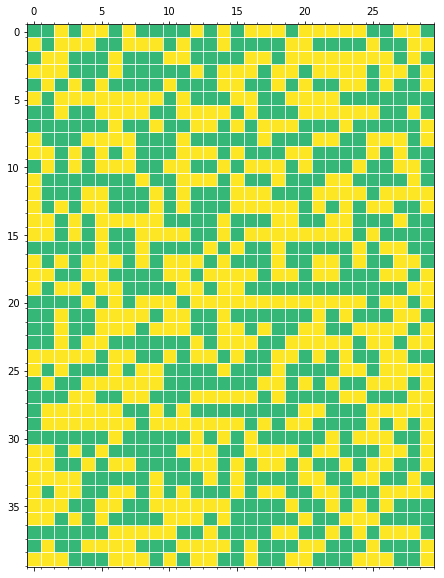

In [351]:
b = Field.random((40, 30), 0.5)
b.display()

And we lit trees on left side of the field

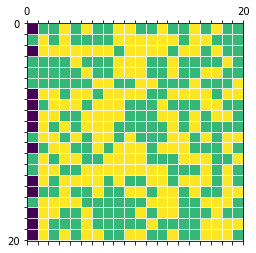

In [8]:
b[:, 0][b[:, 0] == TREE] = BURNING
b.display()

We also need a function which woould update the field

In [9]:
def update_field(field):
    copy = field.copy()
    for (x, y), state in np.ndenumerate(field.matrix):
        if state == TREE and np.any(field.neighbours_of(x, y) == BURNING):
            copy[x, y] = BURNING
        if state == BURNING:
            copy[x, y] = BURNED
    return copy

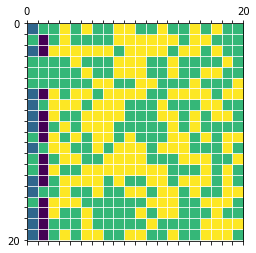

In [10]:
b = update_field(b)
b.display()

# Clusters

Implementation of the Hosher-Kopelman algorithm for cluster detection

In [172]:
class EquivalenceClasses:
    def __init__(self):
        self.classes = []
    def join(self, *values):
        matching_classes = [c for c in self.classes 
                            if any(value in c for value in values )]
        new_list = {*values}
        for _class in matching_classes:
            new_list.update(_class)
            self.classes.remove(_class)
        self.classes.append(new_list)
    def add(self, *values):
        self.classes.append({*values})
    def __contains__(self, value):
        return any(value in _class for _class in self.classes)

In [174]:
eq = EquivalenceClasses()
eq.add(1, 2)
eq.add(4, 5)
eq.classes
eq.join(4, 10, 11, 1)
eq.classes

[{1, 2, 4, 5, 10, 11}]

In [246]:
def clusters(field: Field, occupied: int = TREE) -> np.ndarray:
    cluster = np.zeros_like(field.matrix) - 100
    label = 1
    equivalence_classes = EquivalenceClasses()
    for (x, y), state in np.ndenumerate(field.matrix):
        left = field[x - 1, y] if x - 1 >= 0 else None
        top = field[x, y - 1] if y - 1 >= 0 else None
        left_label = cluster[x - 1, y] if x - 1 >= 0 else None
        top_label = cluster[x, y - 1] if y - 1 >= 0 else None
        if state == occupied:
            if left == occupied and top == occupied:
                if left_label == top_label:
                    cluster[x, y] = left_label  # It doesn't matter which one
                elif left_label != top_label:
                    cluster[x, y] = left_label
                    if left_label in equivalence_classes or top_label in equivalence_classes:
                        equivalence_classes.join(left_label, top_label)
                    else:
                        equivalence_classes.add(left_label, top_label)
            elif left == occupied and top != occupied:
                cluster[x, y] = left_label
            elif left != occupied and top == occupied:
                cluster[x, y] = top_label
            else:
                cluster[x, y] = label
                label += 1
    # Reducing the equivalence classes
    for cls in equivalence_classes.classes:
        _min = min(cls)
        for val in cls - {_min}:
            cluster[cluster == val] = _min
    return cluster  #, equivalence_classes

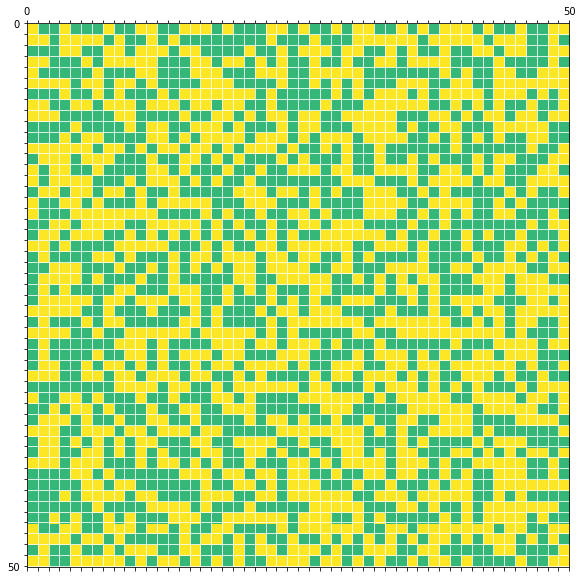

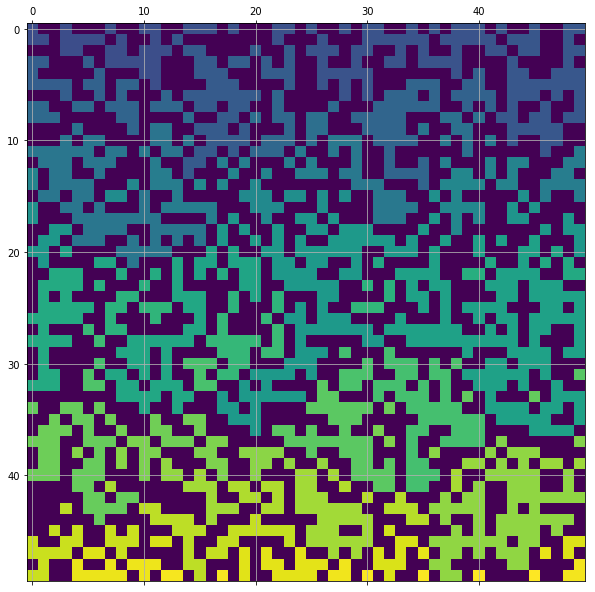

In [248]:
b = Field.random(50, 50, 0.5)
b.display()
c = clusters(b)
plt.matshow(c)
plt.grid()

# Animation test

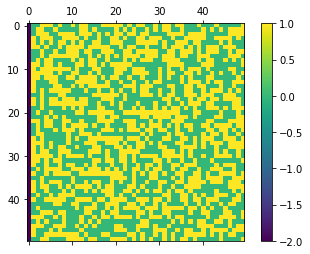

In [21]:
fig, ax = plt.subplots()
image = ax.matshow(t.matrix)
plt.colorbar(image)

In [22]:
def update(frame):
    global t
    if not t.is_burning():
        return
    t = update_field(t)
    image.set_array(t.matrix)

In [20]:
t = Field.random(50, 50, 0.5)
t[:, 0] = BURNING
anim = animation.FuncAnimation(fig, update, frames=100, interval=250, 
                               repeat_delay=2000)

In [23]:
HTML(anim.to_jshtml())

# Custom colormap

In [218]:
np.unique(c)

array([  0,  10,  11,  12,  13,  14,  15,  18,  19,  21,  24,  26,  29,
        30,  31,  32,  33,  34,  35,  36,  38,  39,  42,  43,  44,  45,
        47,  48,  50,  51,  53,  54,  56,  57,  58,  59,  60,  61,  62,
        63,  66,  67,  68,  70,  73,  75,  77,  81,  84,  85,  86,  88,
        89,  93,  96,  98,  99, 101, 102, 103, 104, 105, 108, 109, 110,
       111, 112, 115, 121, 122, 123, 126, 129, 131, 132, 135, 137, 139,
       142, 143, 146, 147, 148, 150, 153, 155, 156, 157, 158, 160, 161,
       162, 165, 166, 168, 170, 172, 174, 175, 176, 177, 178, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 191, 192, 193, 194, 196, 197,
       198, 201, 202, 204, 205, 206, 207, 210, 212, 213, 214, 215, 218,
       219, 220, 223, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236,
       242, 243, 244, 247, 248, 249, 251, 252, 253, 254, 259, 261, 262,
       263, 264, 265, 266, 267, 268, 271, 273, 275, 276, 277, 278, 280,
       281, 282, 285, 287, 290, 291, 297, 300, 302, 303, 304, 30

In [221]:
import matplotlib.cm as cm
import matplotlib.colors

In [206]:
viridis = cm.get_cmap('viridis')

In [233]:
new_colors = viridis(np.linspace(c.min(), 1, len(np.unique(c))))
new_colors[0, 2] = 0.0
    
newcmp = matplotlib.colors.ListedColormap(new_colors)

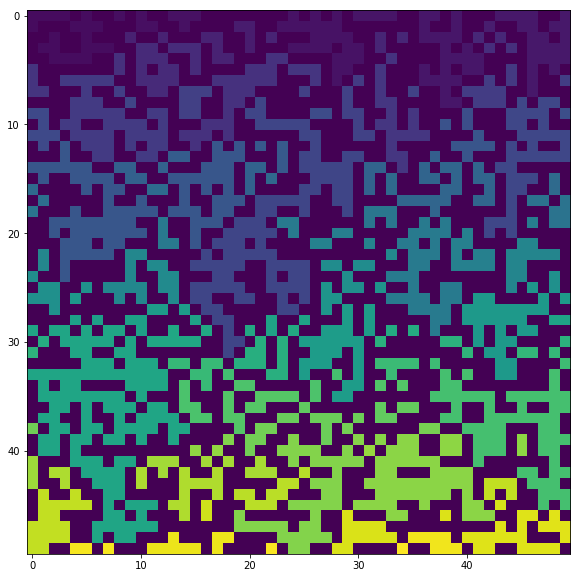

In [241]:
plt.imshow(c)